In [4]:

import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)


N = 3000; D = 2
centers = [[1, 1], [-1, -1], [1, -1]]


N = 3000; D = 4096
M = 300

N = 100000; D = 4096; M = 3000 # 208.63360142707825
# N = 1000000; D = 4096; M = 3000
# #
#



np.random.seed(0)
centers = np.random.choice([-1,1], size=(M,D))


batch_size = 45


n_clusters = len(centers) 
X, labels_true = make_blobs(n_samples=N, n_features=D, centers=centers, cluster_std=0.7)
print(X.shape, labels_true.shape)


(100000, 4096) (100000,)


array([77.73471704, 78.44254383, 78.38583308, ..., 77.01015835,
       77.79393951, 79.02334815])

In [1]:

import time

from sklearn.cluster import KMeans

k_means = KMeans(
    init="k-means++", 
    n_clusters=M,
    n_init=1,
    verbose=True)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

t_batch


KeyboardInterrupt



In [43]:

from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3000,
    batch_size=1024,
    n_init=10,
    random_state=0,
    max_no_improvement=10,
    verbose=True,
)
t0 = time.time()

mbk.fit(X.astype(np.float32))
# mbk.fit((X / np.linalg.norm(X, axis=1, ord=2)[:, np.newaxis]))

t_mini_batch = time.time() - t0

t_mini_batch

Init 1/10 with method k-means++



KeyboardInterrupt



In [37]:

cluster_centers = mbk.cluster_centers_
cluster_labels = mbk.labels_

cluster_centers = cluster_centers / np.linalg.norm(cluster_centers, axis=1, ord=2)[:, np.newaxis]
P = cluster_centers[cluster_labels]
D = np.sum(Xn*P, axis=1)

In [25]:
center_norms = np.linalg.norm(mbk.cluster_centers_, axis=-1)
center_norms

array([64.58758167, 64.59753247, 78.17195115, ..., 64.5411345 ,
       64.63581666, 64.38705158])

In [31]:

print('inertia: ', mbk.inertia_)

# print('centroid norm: ', np.mean(center_norms), center_norms)


inertia:  262516921.7517366


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.721e+03, 2.780e+02]),
 array([0.04197882, 0.13778093, 0.23358305, 0.32938517, 0.42518729,
        0.52098941, 0.61679153, 0.71259364, 0.80839576, 0.90419788,
        1.        ]),
 <BarContainer object of 10 artists>)

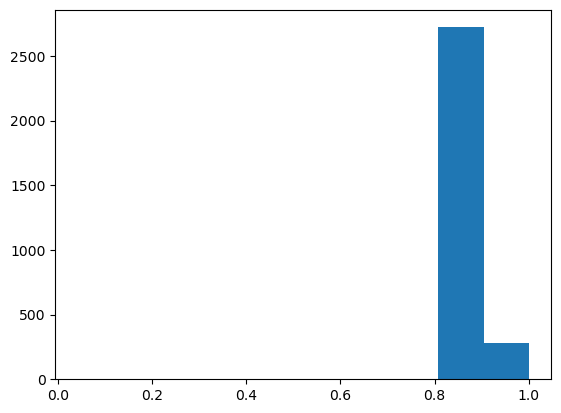

In [23]:
import matplotlib.pyplot as plt
plt.hist(center_norms)

In [41]:

# Data is generated from make_blobs(centers=3000)
# 
# N | D | #clusters | n_init | bsz | KMeans time | MiniBatchKMeans time | KMeans inertia | MiniBatchKMeans inertia
# 100k | 4096 | 3 | 10 | 45 | 208.63360142707825 | 7.031473636627197 | 609463055.9107844 | 609988056.1067324


"""
take-aways
- 
"""

# MiniBatchKMeans

N | D | #clusters | n_init | bsz | time (s) | inertia | comments
100k | 4096 | 3 | 10 | 45 | 7  | 609988056 | -
100k | 4096 | 3000 | 10 | 45 | 883  | 238845223 | n_clusters=3→3000 ⇒ ↓time
100k | 4096 | 3000 | 1  | 45 | 60  | 411357893 | n_init=10→1 ⇒ ↑speed
100k | 4096 | 3000 | 1  | 1024 | 189  | 262201827 | ↑bsz ⇒ ↑inertia
100k | 4096 | 3000 | 1  | 45 | 521  | 38600 | fit(X/norm(X,-1)), inertia not comparable




(609463055.9107844, 609988056.1067324)

In [33]:

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100000 but corresponding boolean dimension is 3000

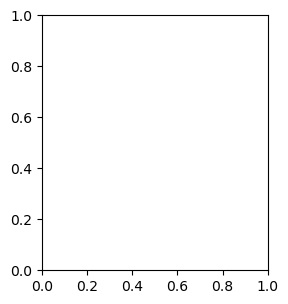

In [38]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

(3000, 4096)